In [2]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A #our data augmentation library
import sys

import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu118
0.17.1+cu118


In [3]:

from pycocotools.coco import COCO

In [4]:
from albumentations.pytorch import ToTensorV2

In [5]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [6]:
class PeopleDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
        self.transforms = get_transforms(train=(split == 'train'))
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target]
        transformed = self.transform(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ
    
    def __len__(self):
        return len(self.ids)


In [7]:
dataset_path = "./dataset"


In [8]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


{0: {'id': 0, 'name': 'People', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Persona', 'supercategory': 'People'}}

In [9]:
classes = [i[1]['name'] for i in categories.items()]
classes

['People', 'Persona']

In [12]:
train_dataset = PeopleDetection(root=dataset_path, transform=get_transforms(True))
# print(train_dataset)
print(len(train_dataset))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
4338


In [13]:
from torchvision.utils import draw_bounding_boxes

(tensor([[[0.0118, 0.0196, 0.0196,  ..., 0.6235, 0.7137, 0.8824],
         [0.0196, 0.0275, 0.0235,  ..., 0.6549, 0.7569, 0.8706],
         [0.0000, 0.0039, 0.0039,  ..., 0.6196, 0.7686, 0.8157],
         ...,
         [0.0275, 0.0118, 0.0000,  ..., 0.3176, 0.3059, 0.3412],
         [0.0118, 0.0000, 0.0000,  ..., 0.3333, 0.7804, 0.3490],
         [0.0078, 0.0000, 0.0000,  ..., 0.8431, 0.4039, 0.2941]],

        [[0.0000, 0.0078, 0.0039,  ..., 0.6275, 0.7176, 0.8824],
         [0.0078, 0.0157, 0.0118,  ..., 0.6588, 0.7608, 0.8745],
         [0.0000, 0.0000, 0.0000,  ..., 0.6235, 0.7725, 0.8196],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.3020, 0.2902, 0.3255],
         [0.0000, 0.0000, 0.0000,  ..., 0.3137, 0.7765, 0.3333],
         [0.0000, 0.0000, 0.0000,  ..., 0.8275, 0.3843, 0.2784]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.6000, 0.6941, 0.8588],
         [0.0000, 0.0000, 0.0000,  ..., 0.6353, 0.7333, 0.8510],
         [0.0000, 0.0000, 0.0000,  ..., 0.5961, 0.7451, 0

C:\Users\antho\AppData\Local\Temp\ipykernel_29088\4206661799.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)


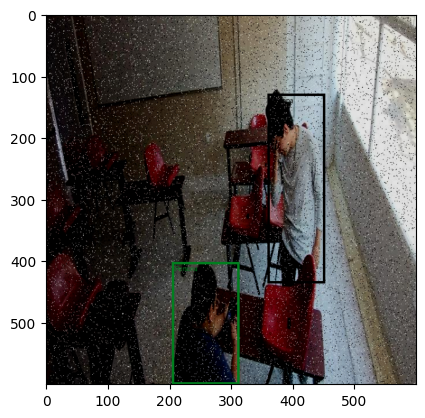

In [14]:
sample = train_dataset[2]
print(sample)
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [15]:
dic = {}
for i in sample[1]['labels']:
    if(classes[i] in dic):
        dic[classes[i.numpy()]] += 1
    else:
        dic[classes[i.numpy()]] = 1
print(dic)

{'Persona': 2}


In [16]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [19]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_fn)


print(len(train_loader))


1085


In [20]:
device = torch.device("cuda")

In [21]:
model = model.to(device)

In [22]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) 

In [23]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000 # do lr warmup
        warmup_iters = min(1000, len(loader) - 1)
        
        lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if lr_scheduler is not None:
            lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [24]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

torch.save(model, 'modelo_completo.pt')

  0%|          | 0/1085 [00:00<?, ?it/s]C:\Users\antho\AppData\Local\Temp\ipykernel_29088\892332294.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
100%|██████████| 1085/1085 [02:14<00:00,  8.07it/s]


Epoch 0, lr: 0.010000, loss: 0.523414, loss_classifier: 0.193281, loss_box: 0.261576, loss_rpn_box: 0.027740, loss_object: 0.040816


100%|██████████| 1085/1085 [02:11<00:00,  8.24it/s]


Epoch 1, lr: 0.010000, loss: 0.478375, loss_classifier: 0.178503, loss_box: 0.242546, loss_rpn_box: 0.027053, loss_object: 0.030274


100%|██████████| 1085/1085 [02:11<00:00,  8.25it/s]


Epoch 2, lr: 0.010000, loss: 0.476153, loss_classifier: 0.176698, loss_box: 0.250591, loss_rpn_box: 0.024907, loss_object: 0.023957


100%|██████████| 1085/1085 [02:11<00:00,  8.24it/s]


Epoch 3, lr: 0.010000, loss: 0.469331, loss_classifier: 0.173484, loss_box: 0.250987, loss_rpn_box: 0.023361, loss_object: 0.021499


100%|██████████| 1085/1085 [02:10<00:00,  8.31it/s]


Epoch 4, lr: 0.010000, loss: 0.464747, loss_classifier: 0.171141, loss_box: 0.251370, loss_rpn_box: 0.022974, loss_object: 0.019262


100%|██████████| 1085/1085 [02:13<00:00,  8.12it/s]


Epoch 5, lr: 0.010000, loss: 0.463776, loss_classifier: 0.170384, loss_box: 0.254037, loss_rpn_box: 0.021647, loss_object: 0.017708


100%|██████████| 1085/1085 [02:17<00:00,  7.87it/s]


Epoch 6, lr: 0.010000, loss: 0.467389, loss_classifier: 0.169808, loss_box: 0.260831, loss_rpn_box: 0.020984, loss_object: 0.015766


100%|██████████| 1085/1085 [02:10<00:00,  8.32it/s]


Epoch 7, lr: 0.010000, loss: 0.455593, loss_classifier: 0.167251, loss_box: 0.251549, loss_rpn_box: 0.020874, loss_object: 0.015920


100%|██████████| 1085/1085 [02:10<00:00,  8.30it/s]


Epoch 8, lr: 0.010000, loss: 0.447428, loss_classifier: 0.162009, loss_box: 0.250509, loss_rpn_box: 0.020033, loss_object: 0.014878


100%|██████████| 1085/1085 [02:10<00:00,  8.35it/s]


Epoch 9, lr: 0.010000, loss: 0.441869, loss_classifier: 0.160641, loss_box: 0.246601, loss_rpn_box: 0.019963, loss_object: 0.014664


# Inference

In [3]:
model = torch.load('./modelo_completo.pt')  # Ajuste o caminho do arquivo .pt
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [33]:
transform = T.Compose([
    # T.Resize((224, 224)),  
    T.ToTensor(),  
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [39]:
image_path = './img1.jpg'  
image = Image.open(image_path).convert("RGB")

In [40]:
input_image = transform(image).unsqueeze(0)

In [41]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
input_image = input_image.to(device)

22


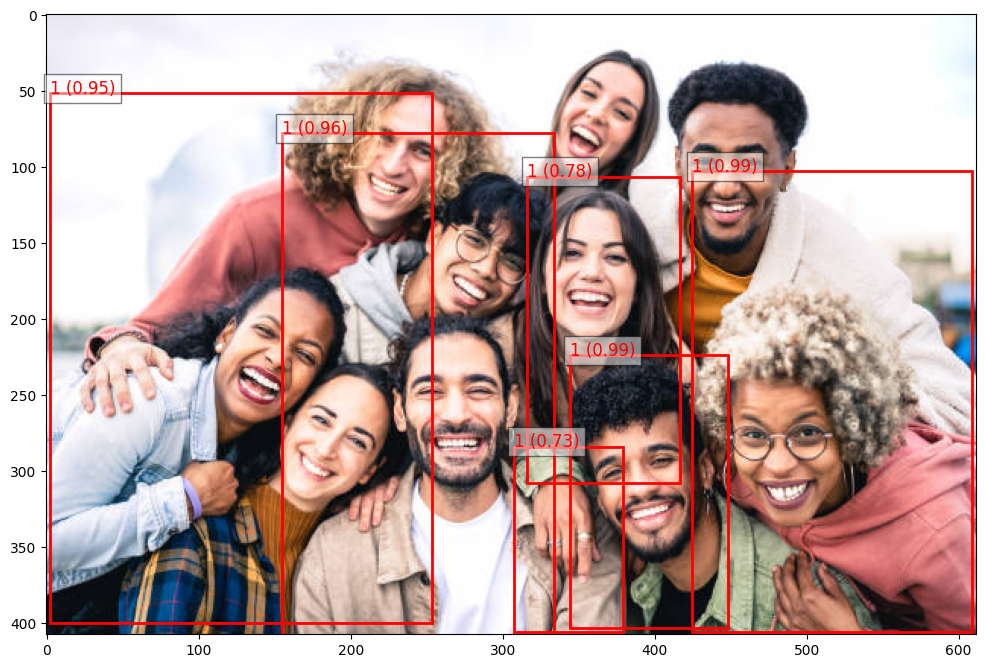

In [44]:
with torch.no_grad(): 
    outputs = model(input_image)

# print(outputs)

boxes = outputs[0]['boxes'].cpu().numpy()  
labels = outputs[0]['labels'].cpu().numpy() 
scores = outputs[0]['scores'].cpu().numpy()  

print(len(labels))

fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)


for box, label, score in zip(boxes, labels, scores):
    if score > 0.7:  
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'{label} ({score:.2f})', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()